<a href="https://colab.research.google.com/github/DM2003/DEEP-LEARNING-PROJECTS/blob/main/PAMAP2_DATASET_SPECTOGRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O pamap2.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
!unzip pamap2.zip

--2024-07-24 15:16:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pamap2.zip’

pamap2.zip              [   <=>              ] 656.29M  42.1MB/s    in 13s     

2024-07-24 15:17:06 (50.5 MB/s) - ‘pamap2.zip’ saved [688167640]

Archive:  pamap2.zip
replace PAMAP2_Dataset/Protocol/subject101.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PAMAP2_Dataset/Protocol/subject102.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PAMAP2_Dataset/Protocol/subject103.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PAMAP2_Dataset/Protocol/subject104.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PAMAP2_Dataset/Protocol/subject105.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace PAMAP2_Dataset/Protocol/

In [28]:
import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

import pickle
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored
from scipy.signal import spectrogram

In [3]:
def load_static_activity_map():
    map = {}

    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    return map

In [4]:
def load_dynamic_activity_map():
  map_dynamic = {}

  map_dynamic[12] = 'ascending_stairs'
  map_dynamic[13] = 'descending_stairs'
  map_dynamic[4] = 'walking'
  map_dynamic[5] = 'running'
  map_dynamic[6] = 'cycling'

  return map_dynamic

In [5]:
def generate_three_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    return [x, y, z]

def generate_four_IMU(name):
    x = name + '_x'
    y = name + '_y'
    z = name + '_z'
    w = name + '_w'
    return [x, y, z, w]

def generate_cols_IMU(name):
    # temp
    temp = name + '_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name + '_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name + '_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name + '_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name + '_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # orientation
    orientation = name + '_4D_orientation'
    orientation = generate_four_IMU(orientation)
    output.extend(orientation)
    return output

def load_IMU():
    output = ['time_stamp', 'activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

def load_subjects(root='/content/PAMAP2_Dataset/Protocol/subject'):
    all_subjects = []
    cols = load_IMU()

    for i in range(101, 110):
        path = root + str(i) + '.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        all_subjects.append(subject)

    output = pd.concat(all_subjects, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [6]:
data.head()

time_stamp  activity_id  heart_rate  hand_temperature  \
0        8.38            0       104.0              30.0   
1        8.39            0         NaN              30.0   
2        8.40            0         NaN              30.0   
3        8.41            0         NaN              30.0   
4        8.42            0         NaN              30.0   

   hand_3D_acceleration_16_x  hand_3D_acceleration_16_y  \
0                    2.37223                    8.60074   
1                    2.18837                    8.56560   
2                    2.37357                    8.60107   
3                    2.07473                    8.52853   
4                    2.22936                    8.83122   

   hand_3D_acceleration_16_z  hand_3D_acceleration_6_x  \
0                    3.51048                   2.43954   
1                    3.66179                   2.39494   
2                    3.54898                   2.30514   
3                    3.66021                   2.33528   
4                    3.70000                   2.23055   

   hand_3D_acceleration_6_y  hand_3D_acceleration_6_z  ...  \
0                   8.76165                   3.35465  ...   
1                   8.55081                   3.64207  ...   
2                   8.53644                   3.73280  ...   
3                   8.53622                   3.73277  ...   
4                   8.59741                   3.76295  ...   

   ankle_3D_gyroscope_y  ankle_3D_gyroscope_z  ankle_3D_magnetometer_x  \
0              0.009250             -0.017580                 -61.1888   
1             -0.004638              0.000368                 -59.8479   
2              0.000148              0.022495                 -60.7361   
3             -0.020301              0.011275                 -60.4091   
4             -0.014303             -0.002823                 -61.5199   

   ankle_3D_magnetometer_y  ankle_3D_magnetometer_z  ankle_4D_orientation_x  \
0                 -38.9599                 -58.1438                     1.0   
1                 -38.8919                 -58.5253                     1.0   
2                 -39.4138                 -58.3999                     1.0   
3                 -38.7635                 -58.3956                     1.0   
4                 -39.3879                 -58.2694                     1.0   

   ankle_4D_orientation_y  ankle_4D_orientation_z  ankle_4D_orientation_w   id  
0                     0.0                     0.0                     0.0  101  
1                     0.0                     0.0                     0.0  101  
2                     0.0                     0.0                     0.0  101  
3                     0.0                     0.0                     0.0  101  
4                     0.0                     0.0                     0.0  101  

[5 rows x 55 columns]

In [7]:
data.isnull().sum()

time_stamp                          0
activity_id                         0
heart_rate                    2610265
hand_temperature                13141
hand_3D_acceleration_16_x       13141
hand_3D_acceleration_16_y       13141
hand_3D_acceleration_16_z       13141
hand_3D_acceleration_6_x        13141
hand_3D_acceleration_6_y        13141
hand_3D_acceleration_6_z        13141
hand_3D_gyroscope_x             13141
hand_3D_gyroscope_y             13141
hand_3D_gyroscope_z             13141
hand_3D_magnetometer_x          13141
hand_3D_magnetometer_y          13141
hand_3D_magnetometer_z          13141
hand_4D_orientation_x           13141
hand_4D_orientation_y           13141
hand_4D_orientation_z           13141
hand_4D_orientation_w           13141
chest_temperature                3563
chest_3D_acceleration_16_x       3563
chest_3D_acceleration_16_y       3563
chest_3D_acceleration_16_z       3563
chest_3D_acceleration_6_x        3563
chest_3D_acceleration_6_y        3563
chest_3D_acc

In [8]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [9]:
data.isnull().sum()

time_stamp                    0
activity_id                   0
heart_rate                    0
hand_temperature              0
hand_3D_acceleration_16_x     0
hand_3D_acceleration_16_y     0
hand_3D_acceleration_16_z     0
hand_3D_acceleration_6_x      0
hand_3D_acceleration_6_y      0
hand_3D_acceleration_6_z      0
hand_3D_gyroscope_x           0
hand_3D_gyroscope_y           0
hand_3D_gyroscope_z           0
hand_3D_magnetometer_x        0
hand_3D_magnetometer_y        0
hand_3D_magnetometer_z        0
hand_4D_orientation_x         0
hand_4D_orientation_y         0
hand_4D_orientation_z         0
hand_4D_orientation_w         0
chest_temperature             0
chest_3D_acceleration_16_x    0
chest_3D_acceleration_16_y    0
chest_3D_acceleration_16_z    0
chest_3D_acceleration_6_x     0
chest_3D_acceleration_6_y     0
chest_3D_acceleration_6_z     0
chest_3D_gyroscope_x          0
chest_3D_gyroscope_y          0
chest_3D_gyroscope_z          0
chest_3D_magnetometer_x       0
chest_3D

In [10]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Number of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Number of uniqe activitys in the data:  12


In [11]:
static_activities = load_static_activity_map()
dynamic_activities = load_dynamic_activity_map()

In [12]:
# Filter data for static activities
static_data = data[data['activity_id'].isin(static_activities.keys())] # This line filters the data DataFrame to include only rows where the activity_id column matches one of the activity IDs specified in the static_activities dictionary.
static_features = static_data.drop(columns=['time_stamp', 'activity_id', 'id'], axis=1) # This line creates a new DataFrame static_features that contains all columns from static_data except time_stamp, activity_id, and id.
static_target = static_data['activity_id'] # This line extracts the activity_id column from static_data and assigns it to static_target.

In [13]:
# Filter data for dynamic activities
dynamic_data = data[data['activity_id'].isin(dynamic_activities.keys())] # This line filters the data DataFrame to include only rows where the activity_id column matches one of the activity IDs specified in the dynamic_activities dictionary.
dynamic_features = dynamic_data.drop(columns=['time_stamp', 'activity_id', 'id'], axis=1) # This line creates a new DataFrame dynamic_features that contains all columns from dynamic_data except time_stamp, activity_id, and id.
dynamic_target = dynamic_data['activity_id'] # This line extracts the activity_id column from dynamic_data and assigns it to dynamic_target.

In [14]:
# Convert to NumPy arrays
static_features_array = static_features.to_numpy() # Converts it to Numpy Array
dynamic_features_array = dynamic_features.to_numpy() # Converts it to Numpy Array

In [15]:
# Define the segment_data function
def segment_data(data, window_size, stride): # The function is designed to divide a continuous dataset into overlapping segments or windows.

    segments = [] # Used to store the individual segments or windows of the data as they are created.

    num_windows = (len(data) - window_size) // stride + 1 # Calculates the total number of segments or windows that can be created from the data.
    """len(data) - window_size: Determines how many starting points there are in the data for the window.
      // stride: Divides this by the stride to get the number of full windows that can be created.
      + 1: Includes the last window, which might be partial."""

    for start in range(0, num_windows * stride, stride): # Generates starting indices for the windows, starting from 0 up to (num_windows * stride) with a step size of (stride)
        end = start + window_size # Compute the end index of the window
        segment = data[start:end] # Extract the portion of data from start to end and store it in segment.
        segments.append(segment) # Add the segment to the segments list.
    return np.array(segments) # Only return the segments

In [16]:
window_size = 100  # Size of each window
stride = 50  # Overlapping between windows

In [17]:
# Segment data
static_segments = segment_data(static_features_array, window_size, stride) # Call the function with a single output
dynamic_segments = segment_data(dynamic_features_array, window_size, stride) # Call the function with a single output

In [18]:
import matplotlib.pyplot as plt
from scipy.signal import stft

In [19]:
# Checking to ensure length of static_target matches the length of static_features_array
print("Length of static_target:", len(static_target))
print("Length of static_features_array:", len(static_features_array))

Length of static_target: 567642
Length of static_features_array: 567642


In [20]:
# Checking to ensure length of dynamic_target matches the length of dynamic_features_array
print("Length of dynamic_target:", len(dynamic_target))
print("Length of dynamic_features_array:", len(dynamic_features_array))

Length of dynamic_target: 723720
Length of dynamic_features_array: 723720


In [21]:
# Aggregate data for each static activity using boolean indexing
def aggregate_data_for_activity(data, target, activity_id):
  """data: The dataset containing features (e.g., sensor readings) for different activities
     target: The column containing the activity IDs or labels for each data point.
     activity_id: The specific activity ID we want to filter and aggregate data for."""

  mask = target == activity_id # Creates a boolean mask that identifies which rows in the target column match the specified activity_id.
  return data[mask] # Applies the boolean mask to the data DataFrame to select only the rows where the mask is True. This returns the subset of data that corresponds to the specified activity_id.

In [22]:
# Aggregate data for each dynamic activity using boolean indexing
def aggregate_data_for_dynamic_activity(data, target, activity_id):
    mask = target == activity_id
    return data[mask]

In [23]:
# Creates a dictionary to store aggregated data for each static activity
aggregated_static_data = {activity_id: aggregate_data_for_activity(static_features_array, static_target, activity_id)
                           for activity_id in static_activities.keys()}


In [24]:
# Creates a dictionary to store aggregated data for each dynamic activity
aggregated_dynamic_data = {activity_id: aggregate_data_for_activity(dynamic_features_array, dynamic_target, activity_id)
                           for activity_id in dynamic_activities.keys()}

In [25]:
def generate_spectrogram(data, fs=50, nperseg=256):
  """data: The time-series data for which you want to compute the spectrogram.
     fs: Sampling frequency of the data (default is 50 Hz).
     nperseg: Length of each segment for the STFT (default is 256 samples)."""

  f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg) # Calls the spectogram function to compute the spectogram. nperseg: Number of samples per segment for computing the STFT.

  return f, t, Sxx
  """f: Array of frequency bins.
     t: Array of time bins.
     Sxx: 2D array of the spectrogram, where each entry represents the power spectral density at a specific frequency and time."""

In [26]:
def generate_spectrogram_dynamic(data, fs=50, nperseg=256):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)
    return f, t, Sxx

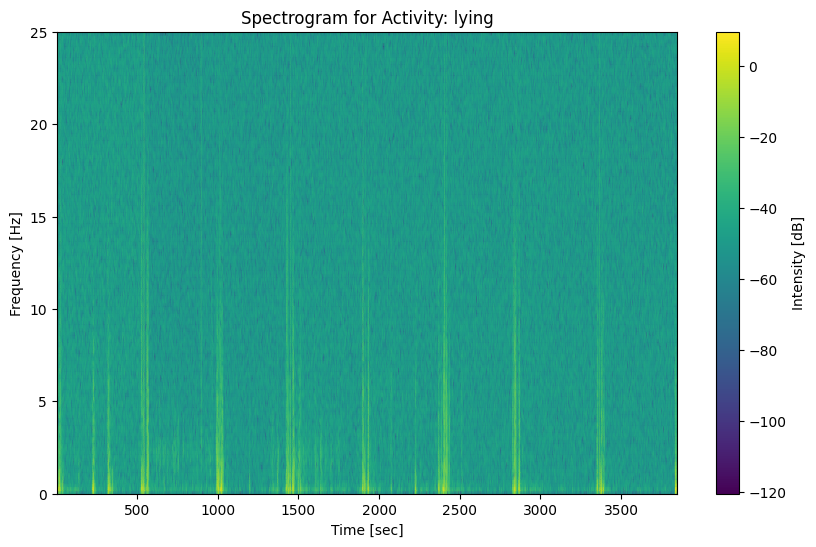

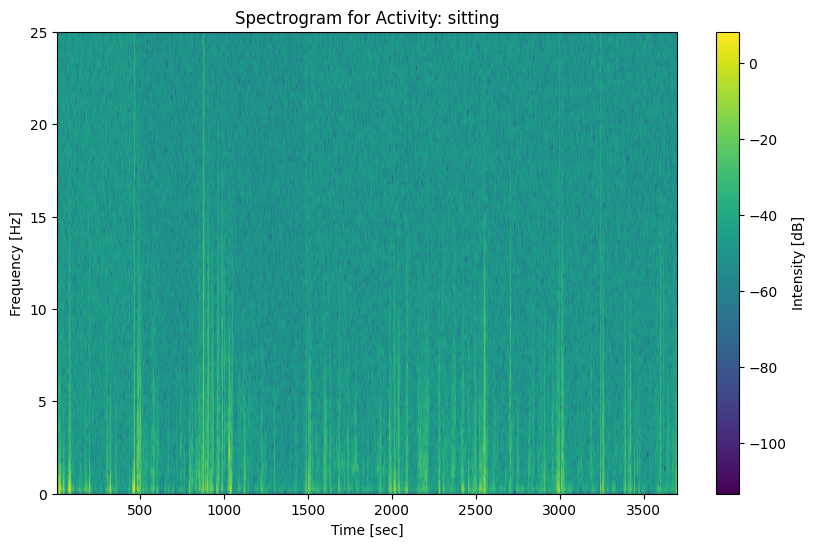

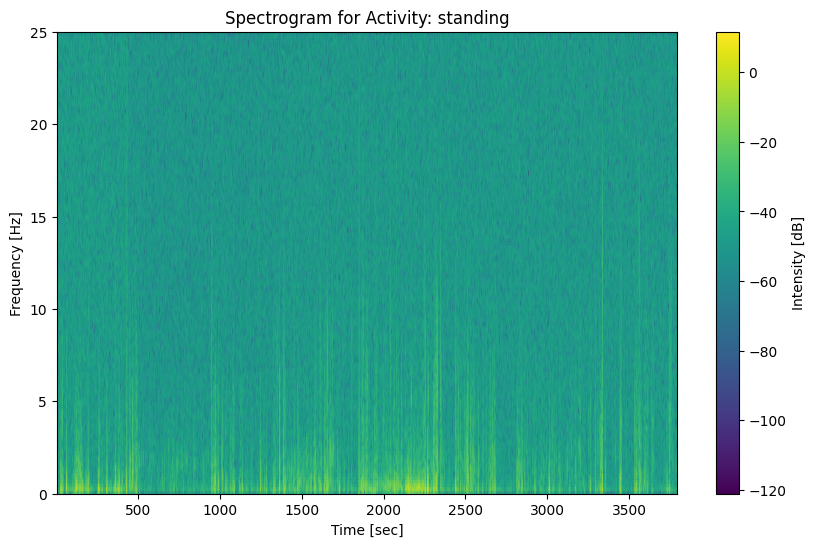

In [29]:
# Plot spectrogram for each static activity
for activity_id, activity_data in aggregated_static_data.items(): # Loop iterates through each static activity in the aggregated_static_data dictionary.
    if activity_data.size > 0: # Ensures that there is data available for the current activity. If activity_data is empty, it skips to the next iteration.

        # Aggregate data across all channels
        aggregated_activity_data = np.mean(activity_data, axis=1)  # Mean across all channels
        f, t, Sxx = generate_spectrogram(aggregated_activity_data) # Calls the generate_spectrogram function on aggregated_activity_data to compute the spectrogram of the aggregated activity data.

        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
        """t: Time bins (x-axis)
           f: Frequency bins (y-axis)
           10 * np.log10(Sxx): Converts the spectrogram matrix Sxx to decibels (dB) for better visualization"""

        plt.title(f'Spectrogram for Activity: {static_activities[activity_id]}')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(label='Intensity [dB]')
        plt.show()
    else:
        print(f"No data available for activity {static_activities[activity_id]}")

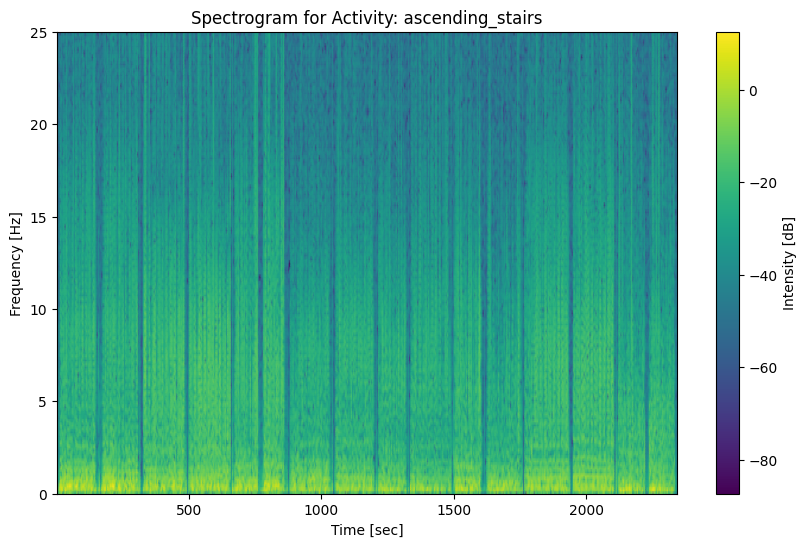

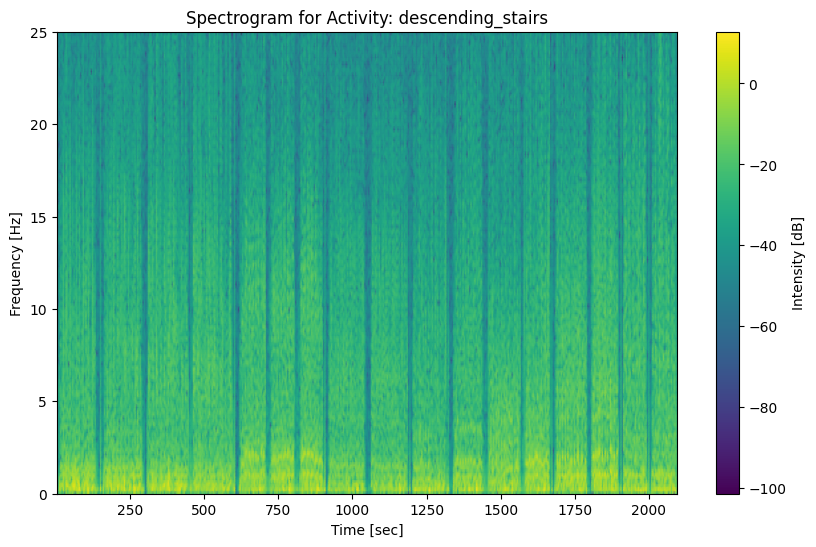

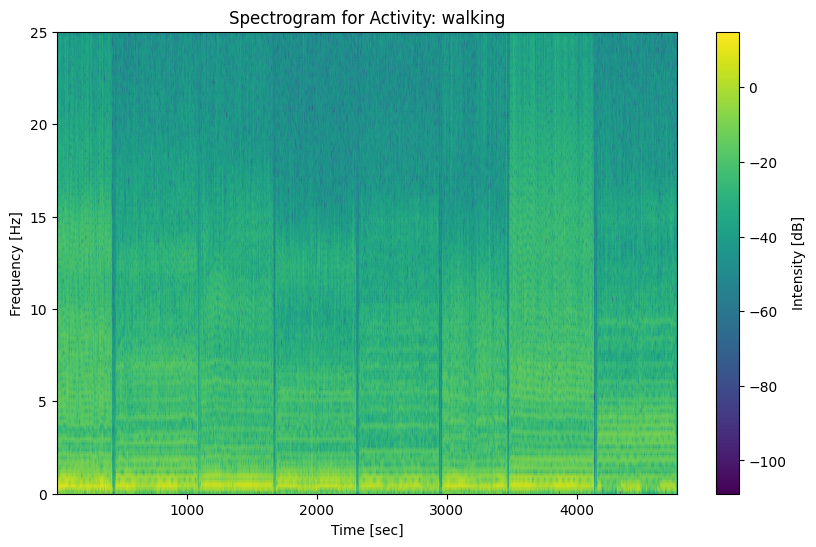

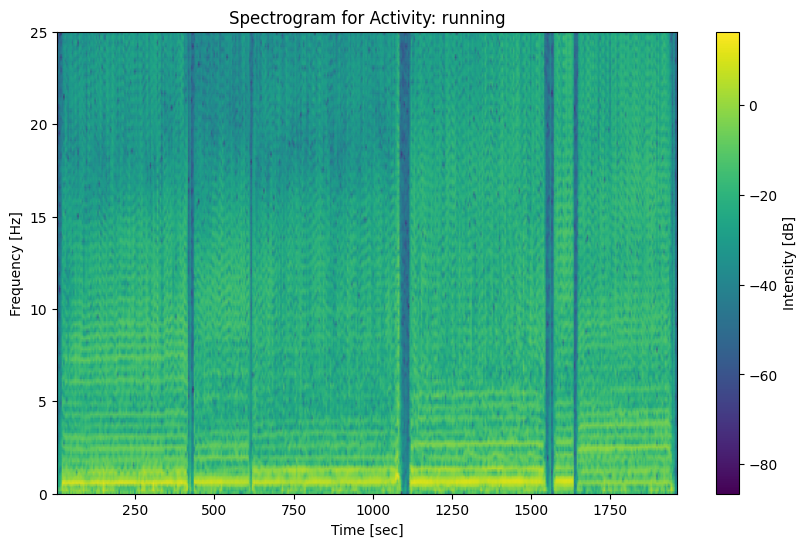

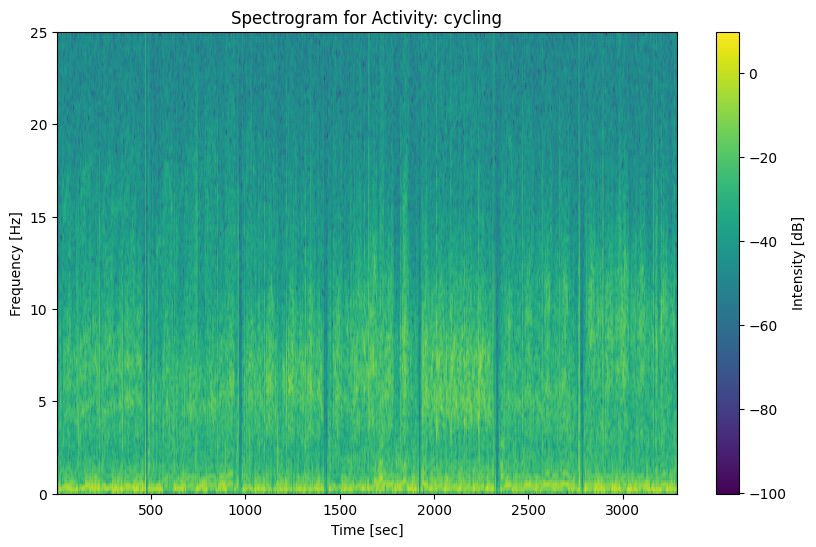

In [30]:
# Plot spectrogram for each dynamic activity
for activity_id, activity_data in aggregated_dynamic_data.items():
    if activity_data.size > 0:
        # Aggregate data across all channels
        aggregated_activity_data = np.mean(activity_data, axis=1)  # Mean across all channels
        f, t, Sxx = generate_spectrogram_dynamic(aggregated_activity_data)

        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
        plt.title(f'Spectrogram for Activity: {dynamic_activities[activity_id]}')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar(label='Intensity [dB]')
        plt.show()
    else:
        print(f"No data available for activity {dynamic_activities[activity_id]}")

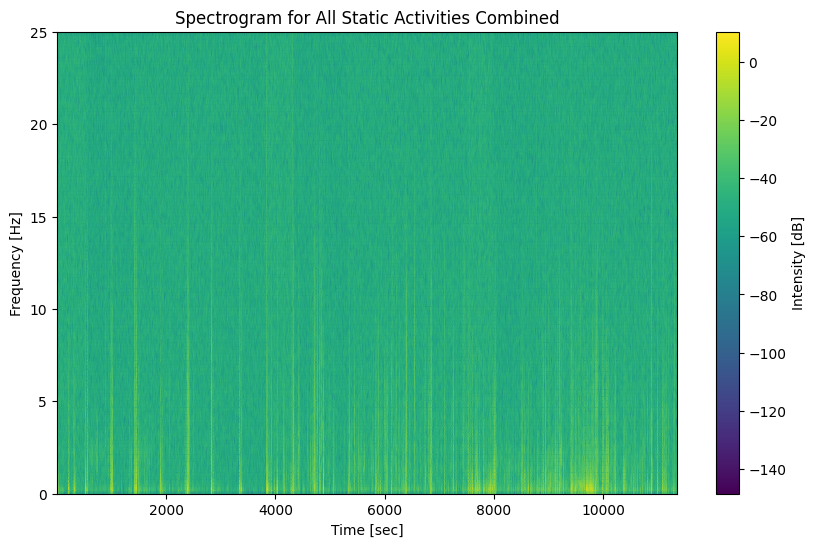

In [31]:
def generate_spectrogram_static_whole(data, fs=50, nperseg=256):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)
    return f, t, Sxx

# Combine data from all static activities
combined_static_data = np.concatenate(list(aggregated_static_data.values()), axis=0)

# Aggregate data across all channels
aggregated_static_data_combined = np.mean(combined_static_data, axis=1)  # Mean across all channels

# Generate spectrogram
f, t, Sxx = generate_spectrogram_static_whole(aggregated_static_data_combined)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram for All Static Activities Combined')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.show()


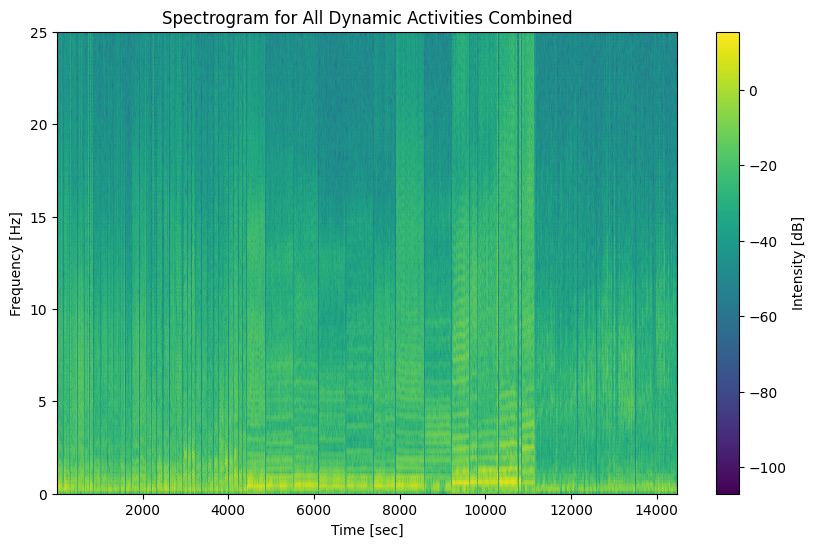

In [32]:
def generate_spectrogram_dynamic_whole(data, fs=50, nperseg=256):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg)
    return f, t, Sxx

# Combine data from all static activities
combined_dynamic_data = np.concatenate(list(aggregated_dynamic_data.values()), axis=0)

# Aggregate data across all channels
aggregated_dynamic_data_combined = np.mean(combined_dynamic_data, axis=1)  # Mean across all channels

# Generate spectrogram
f, t, Sxx = generate_spectrogram_dynamic_whole(aggregated_dynamic_data_combined)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Spectrogram for All Dynamic Activities Combined')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.show()